# CS 4993 Independent Study – Machine Learning with COVID Data

***Professor: [Haiyang Shen](https://engineering.virginia.edu/faculty/haiying-shen)***  
***Researcher: [Iain Muir](https://www.linkedin.com/in/iain-muir-b37718164/) | iam9ez***

*Github Project:* https://github.com/iainmuir6/machineLearning_covidData  
*Last Updated: June 14th, 2021*  

*References*
* [CS 4774 ML Material – Professor Rich Nguyen](https://www.cs.virginia.edu/~nn4pj/teaching)
* [Steps to Building Machine Learning Model](https://analyticsindiamag.com/the-7-key-steps-to-build-your-machine-learning-model/)
* [Steps to Data Preprocessing](https://hackernoon.com/what-steps-should-one-take-while-doing-data-preprocessing-502c993e1caa)
* [Handling Missing Values](https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e)
* [Feature Selection I](https://towardsdatascience.com/the-5-feature-selection-algorithms-every-data-scientist-need-to-know-3a6b566efd2)
* [Feature Selection II](https://machinelearningmastery.com/feature-selection-machine-learning-python/)
* [Keras Neural Network I](https://towardsdatascience.com/3-ways-to-create-a-machine-learning-model-with-keras-and-tensorflow-2-0-de09323af4d3)
* [GAN Github Repository – codyznash](https://github.com/codyznash/GANs_for_Credit_Card_Data/blob/7f7e2dfb6ab15eb0d520fa6611fe03d6f8646141/GAN_171103.py#L47)
* [GAN I](https://datasciencecampus.ons.gov.uk/projects/generative-adversarial-networks-gans-for-synthetic-dataset-generation-with-binary-classes/)
* [GAN II](https://nbviewer.jupyter.org/github/codyznash/GANs_for_Credit_Card_Data/blob/master/GAN_comparisons.ipynb#Generated%20Data%20Testing)

## Table of Contents <a class="anchor" id="toc"></a>
* **[0. Import Packages](#setup)**
    * [0.1 General Imports](#imp1)
    * [0.2 ML Imports](#imp2)
* **[1. Read Excel File](#data)**
    * [1.1 Data Overview](#overview)
    * [1.2 Descriptive Statistics](#stats)
    * [1.3 Inspect Null Data](#null)
* **[2. Data Preparation](#prep)**
    * [2.1 Drop Columns](#drop)
    * [2.2 Handle Categorical Variables](#handle1)
        * *[2.2.1 Manual Conversion](#manual)*
        * *[2.2.2 Encoding](#encoding)*
        * *[2.2.3 Categorical Codes](#codes)*
    * [2.3 Handle Missing Values](#handle2)
    * [2.4 Feature Scaling](#scaling)
    * [2.5 Train / Test Split](#split)
    * [2.6 Final Prepared Data](#final_data)
* **[3. Feature Selection I](#feature)**
    * [3.1 Pearson Correlation](#corr)
    * [3.2 Chi-Squared Test](#chi_sq)
    * [3.3 Recursive Feature Elimination](#rfe)
    * [3.4 SelectFromModel: Lasso](#lasso)
    * [3.5 SelectFromModel: Random Forest Classifier](#rfc)
    * [3.6 Cumulative Feature Selection](#cum)
* **[4. Model Selection](#model)**
    * [4.1 Train / Test Data](#tt)
    * [4.2 Model Evaluation Functions](#funcs)
    * [4.3 Model Construction](#models)
        * *[4.3.1 Decision Tree](#dt)*
        * *[4.3.2 Random Forest Classifier](#rfc2)*
        * *[4.3.3 Simple Deep Neural Network](#dnn)*
        * *[4.3.4 Convolutional Neural Network](#cnn)*
    * [4.4 Simultaneous Model Evaluation](#eval)
    * [4.5 RandomizedSearch](#search)
* **[5. Generative Adverserial Networks](#gan)**
    * [5.1 Network Setup](#setup2)
    * [5.2 Training GAN Models](#train)
        * [5.2.1 GAN](#gan2)
        * [5.2.2 CGAN](#cgan)
        * [5.2.3 WGAN + WCGAN](#wgan)
    * [5.3 Loss Information](#loss)
    * [5.4 Generate New Data](#new_data)
    * [5.5 Training Models on New Data](#train_gan)
    * [5.6 Plot Real vs Test Data](#plot)
    * [5.7 Feature Importance](#importance)
* **[6. Retrain Models with GAN Data](#retrain)**
    * [6.1 Re-Prepare Data](#prep2)
    * [6.2 Re-Train Models](#retrain2)
* **[7. Final Model Training with Feature Selection](#final)**
    * [7.1 Define Models and Variables](#define)
    * [7.2 Model Performance w/o GAN](#perf1)
    * [7.3 Model Performance with GAN](#perf2)

## 0. Import Packages <a class="anchor" id="setup"></a>

[Table of Contents](#toc)

#### 0.1 General Imports <a class="anchor" id="imp1"></a>

In [427]:
from IPython.display import Markdown, Image, display
from scipy.stats import reciprocal
import matplotlib.pyplot as plt
from matplotlib import cm
import missingno as msno
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import random
import os

#### 0.2 ML Imports <a class="anchor" id="imp2"></a>

In [428]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO
import pydotplus
import sklearn

from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, Embedding, LSTM
from keras.layers import LeakyReLU, PReLU, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import tensorflow.compat.v1 as tf
from tensorflow import keras
tf.disable_v2_behavior()

import xgboost as xgb
from GAN import GAN

In [429]:
tf.__version__

'2.3.0'

In [430]:
keras.__version__

'2.4.0'

In [431]:
sklearn.__version__

'0.21.2'

In [432]:
SEED = 0

## 1. Read Excel File <a class="anchor" id="data"></a>

[Table of Contents](#toc)

#### 1.1 Data Overview <a class="anchor" id="overview"></a>

In [433]:
df = pd.read_excel('ed_pred.xlsx')
df = df.reset_index()
df.head(5)

,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26,31,2.5,82.0,14,26.0,80.0,8.5,4.3,0.5
1,1,2,0,NaN,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,19,11,0.9,83.0,73,NaN,100.0,8.1,4.6,0.6
2,2,3,0,NaN,None Detected,55,African American,Non-Hispanic,Male,83.0,...,23,9,1.2,123.0,26,29.0,106.0,7.1,4.0,0.7
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,30,45,1.6,297.0,22,NaN,78.0,7.8,3.7,0.5
4,4,5,0,NaN,None Detected,67,African American,Non-Hispanic,Female,90.0,...,27,25,1.0,96.0,12,18.0,122.0,7.4,3.5,0.2


In [434]:
df.shape

(7380, 41)

In [435]:
target = 'COVIDResult'
df.columns

Index(['index', 'patno', 'Admitted', 'AdmittingDepartment', 'COVIDResult',
       'Age', 'FirstRace', 'Ethnicity', 'Sex', 'heart_rate', 'sbp', 'dbp',
       'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit',
       'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c',
       'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc',
       'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c',
       'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride',
       'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose',
       'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein',
       'cmp_albumin', 'cmp_bilirubin'],
      dtype='object')

###### Column Description
Note (src - [Walk-In-Lab](https://www.walkinlab.com/products/view/complete-blood-count-cbc-comprehensive-metabolic-panel-cmp-14-blood-test-panel#:~:text=A%20CBC%20also%20helps%20your,anemia%2C%20and%20several%20other%20disorders.&text=Comprehensive%20Metabolic%20Panel%20)): 

CBC == [Complete Blood Count](https://www.mayoclinic.org/tests-procedures/complete-blood-count/about/pac-20384919)
* Complete Blood Count (CBC) gives important information about the numbers and kinds of cells in the blood, especially red blood cells, white blood cells, and platelets. A CBC helps your health professional check any symptoms, such as fatigue, weakness, or bruising, that you may have. A CBC also helps your health professional diagnose conditions, such as infection, anemia, and several other disorders.

CMP == [Comprehensive Metabolic Panel](https://www.mayocliniclabs.com/test-catalog/Clinical+and+Interpretive/113631)
* Comprehensive Metabolic Panel (CMP-14) with eGFR is a group of 14 laboratory tests ordered to give information about the current status of your liver, kidneys, and electrolyte and acid/base balance.  The test gives the current status of your blood sugar and blood proteins also.

#### 1.2 Descriptive Statistics <a class="anchor" id="stats"></a>

In [436]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     7380 non-null   int64  
 1   patno                     7380 non-null   int64  
 2   Admitted                  7380 non-null   int64  
 3   AdmittingDepartment       3003 non-null   object 
 4   COVIDResult               7380 non-null   object 
 5   Age                       7380 non-null   int64  
 6   FirstRace                 7379 non-null   object 
 7   Ethnicity                 7380 non-null   object 
 8   Sex                       7380 non-null   object 
 9   heart_rate                7352 non-null   float64
 10  sbp                       7292 non-null   float64
 11  dbp                       7292 non-null   float64
 12  pulse_ox                  7346 non-null   float64
 13  resp_rate                 7312 non-null   float64
 14  height  

In [437]:
df.describe()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
count,7380.000000,7380.000000,7380.000000,7380.000000,7352.000000,7292.000000,7292.000000,7346.000000,7312.000000,456.000000,...,3874.000000,3872.000000,6286.000000,5570.000000,6286.000000,6286.000000,4767.000000,5399.000000,5175.000000,5402.000000
mean,3689.500000,3690.500000,0.406911,48.977642,94.529788,135.998354,76.034696,97.064661,21.029130,65.971491,...,0.740428,1.492485,137.104677,4.043447,102.562997,137.406141,55.627858,114.154843,7.210473,3.846113
std,2130.566826,2130.566826,0.491291,23.525661,23.352438,27.256409,15.302797,3.832935,6.762566,7.635750,...,0.545253,2.276703,4.366669,0.603037,5.600923,92.857337,154.142598,89.983238,0.843891,0.577974
min,0.000000,1.000000,0.000000,0.000000,0.000000,46.000000,0.000000,25.000000,0.000000,2.000000,...,0.000000,0.000000,107.000000,2.000000,60.000000,22.000000,7.000000,21.000000,2.400000,1.000000
25%,1844.750000,1845.750000,0.000000,31.000000,78.000000,118.000000,65.000000,96.000000,18.000000,63.000000,...,0.460000,0.100000,135.000000,3.700000,100.000000,94.000000,23.000000,71.000000,6.700000,3.500000
50%,3689.500000,3690.500000,0.000000,52.000000,92.000000,133.000000,75.000000,98.000000,20.000000,67.000000,...,0.670000,0.800000,138.000000,4.000000,103.000000,109.000000,31.000000,90.000000,7.200000,3.900000
75%,5534.250000,5535.250000,1.000000,67.000000,107.000000,151.000000,86.000000,99.000000,22.000000,70.000000,...,0.940000,2.000000,140.000000,4.300000,106.000000,140.000000,46.000000,123.000000,7.700000,4.200000
max,7379.000000,7380.000000,1.000000,119.000000,235.000000,258.000000,147.000000,100.000000,111.000000,77.000000,...,17.790000,41.100000,182.000000,8.900000,143.000000,1576.000000,6479.000000,1126.000000,11.300000,6.300000


In [438]:
df.corr()

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cbc_monocyte_c,cbc_eosinophil_perc.2,cmp_sodium,cmp_potassium,cmp_chloride,cmp_glucose,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin
index,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
patno,1.000000,1.000000,-0.030377,-0.071132,-0.014543,-0.013479,-0.002088,0.066634,-0.031710,-0.017314,...,0.006011,0.000322,0.039232,-0.005859,0.026758,-0.010492,-0.036648,-0.011070,0.016393,0.045855
Admitted,-0.030377,-0.030377,1.000000,0.259000,0.071533,-0.034520,-0.083964,-0.187805,0.141345,0.006556,...,0.090950,-0.122416,-0.139857,0.123330,-0.145144,0.125331,0.098732,0.117501,-0.169298,-0.301735
Age,-0.071132,-0.071132,0.259000,1.000000,-0.343054,0.255632,0.021500,-0.233759,-0.128765,0.237857,...,-0.068070,-0.003148,-0.077553,0.129890,-0.137116,0.097948,-0.014016,-0.091849,-0.147716,-0.312481
heart_rate,-0.014543,-0.014543,0.071533,-0.343054,1.000000,-0.128325,0.032385,-0.018398,0.397967,-0.277916,...,0.100502,-0.102094,-0.062122,-0.048065,-0.073826,0.074114,0.025044,0.123586,0.046071,0.021046
sbp,-0.013479,-0.013479,-0.034520,0.255632,-0.128325,1.000000,0.700990,0.012399,-0.054224,0.129512,...,-0.037211,0.056011,0.089829,-0.016583,0.003022,0.052785,-0.058817,-0.102502,0.195652,0.193473
dbp,-0.002088,-0.002088,-0.083964,0.021500,0.032385,0.700990,1.000000,0.044760,-0.038692,0.178501,...,-0.019228,0.026571,0.119920,-0.055991,0.036059,0.017755,-0.010922,-0.091883,0.268447,0.288271
pulse_ox,0.066634,0.066634,-0.187805,-0.233759,-0.018398,0.012399,0.044760,1.000000,-0.203094,0.003070,...,-0.002565,0.017027,0.012110,-0.118440,0.099202,-0.105208,-0.052456,-0.005379,0.037321,0.123265
resp_rate,-0.031710,-0.031710,0.141345,-0.128765,0.397967,-0.054224,-0.038692,-0.203094,1.000000,-0.339655,...,0.078115,-0.037053,-0.013692,0.118477,-0.008239,0.076232,0.037055,0.099776,-0.078270,-0.083926
height,-0.017314,-0.017314,0.006556,0.237857,-0.277916,0.129512,0.178501,0.003070,-0.339655,1.000000,...,-0.033168,-0.156211,0.055314,-0.173582,0.030194,0.057657,0.005574,-0.187236,0.127008,0.030490


In [439]:
print(df[target].value_counts())

None Detected    6910
Detected          470
Name: COVIDResult, dtype: int64


In [440]:
none_detected_dups = sum(df.loc[df[target]=='None Detected'].duplicated())
detected_dups = sum(df.loc[df[target]=='Detected'].duplicated())
total_dups = none_detected_dups + detected_dups

print('None Detected Duplicates:', none_detected_dups)
print('Detected Duplicates:', detected_dups)
print('Total Duplicates:', total_dups)
print('Fraction Duplicated:', total_dups / len(df))

None Detected Duplicates: 0
Detected Duplicates: 0
Total Duplicates: 0
Fraction Duplicated: 0.0


#### 1.3 Inspect Null Data <a class="anchor" id="null"></a>

In [441]:
print('Total Number of NULL Data Points:', df.isnull().sum().sum())
df.isnull().sum()

Total Number of NULL Data Points: 69411


index                          0
patno                          0
Admitted                       0
AdmittingDepartment         4377
COVIDResult                    0
Age                            0
FirstRace                      1
Ethnicity                      0
Sex                            0
heart_rate                    28
sbp                           88
dbp                           88
pulse_ox                      34
resp_rate                     68
height                      6924
wght                        4132
cbc_wbc                     1124
cbc_hematocrit              1124
cbc_hemoglobin              1123
cbc_platelets               1124
cbc_neutrophil_c            3507
cbc_eosinophil_perc         3508
cbc_lymphocyte_c            3506
cbc_lymphocyte_perc         3506
cbc_eosinophil_c            3508
cbc_eosinophil_perc.1       3508
cbc_monocyte_c              3506
cbc_eosinophil_perc.2       3508
cmp_sodium                  1094
cmp_potassium               1810
cmp_chlori

In [442]:
d = {
    col: round(df[col].isnull().sum() * 100 / len(df[col]), 4)
    for col in df
}
d = dict(sorted(d.items(), key=lambda item: item[1], reverse=True))
majority_null = [k for k, v in d.items() if v > 50.0]

print("Null Data Points by variable")
d

Null Data Points by variable


{'height': 93.8211,
 'AdmittingDepartment': 59.3089,
 'wght': 55.9892,
 'cbc_eosinophil_perc': 47.5339,
 'cbc_eosinophil_c': 47.5339,
 'cbc_eosinophil_perc.1': 47.5339,
 'cbc_eosinophil_perc.2': 47.5339,
 'cbc_neutrophil_c': 47.5203,
 'cbc_lymphocyte_c': 47.5068,
 'cbc_lymphocyte_perc': 47.5068,
 'cbc_monocyte_c': 47.5068,
 'cmp_ast': 35.4065,
 'cmp_total_protein': 29.878,
 'cmp_alkaline_phosphatase': 26.8428,
 'cmp_alt': 26.8157,
 'cmp_bilirubin': 26.8157,
 'cmp_albumin': 26.8022,
 'cmp_potassium': 24.5257,
 'cbc_wbc': 15.2304,
 'cbc_hematocrit': 15.2304,
 'cbc_platelets': 15.2304,
 'cbc_hemoglobin': 15.2168,
 'cmp_bicarbonate': 14.9593,
 'cmp_sodium': 14.8238,
 'cmp_chloride': 14.8238,
 'cmp_bun': 14.8238,
 'cmp_creatinine': 14.8238,
 'cmp_glucose': 14.8238,
 'sbp': 1.1924,
 'dbp': 1.1924,
 'resp_rate': 0.9214,
 'pulse_ox': 0.4607,
 'heart_rate': 0.3794,
 'FirstRace': 0.0136,
 'index': 0.0,
 'patno': 0.0,
 'Admitted': 0.0,
 'COVIDResult': 0.0,
 'Age': 0.0,
 'Ethnicity': 0.0,
 'Sex': 

<AxesSubplot:>

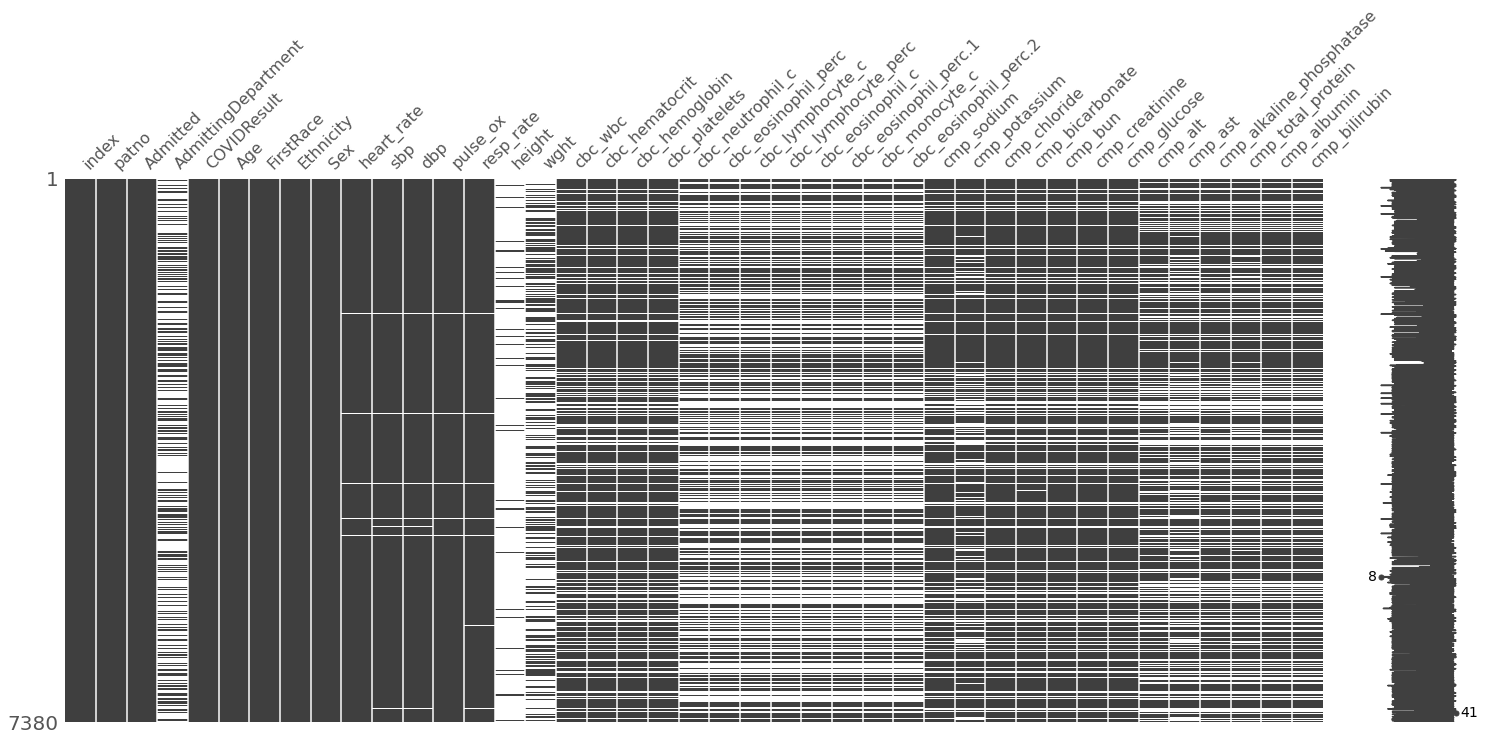

In [443]:
msno.matrix(df)
# msno.heatmap(df)

## 2. Data Preparation <a class="anchor" id="prep"></a>

[Table of Contents](#toc)

#### 2.1 Drop Columns <a class="anchor" id="drop"></a>

In [444]:
drop = False

In [445]:
if drop:
    trim_df = df.drop(columns=majority_null)
    trim_df = trim_df.drop(columns=['index', 'patno'])
    trim_df.head(5)
else:
    trim_df = df

In [446]:
trim_df.isnull().sum().sum()

69411

#### 2.2 Handle Categorical Variables <a class="anchor" id="handle1"></a>

In [447]:
trim_df.select_dtypes(include=['object']).columns

Index(['AdmittingDepartment', 'COVIDResult', 'FirstRace', 'Ethnicity', 'Sex',
       'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_alt',
       'cmp_bilirubin'],
      dtype='object')

###### 2.2.1 Manual Conversion <a class="anchor" id="manual"></a>

In [448]:
num_cat_cols = [
    'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_alt', 'cmp_bilirubin'
]
less_than_list = [
    '<5', '<2', '<0.2', '<6', '<0.1'
]


def replace_cat(val, less, num):
    if val == less:
        return random.uniform(0, num) if "." in less else random.randint(0, num)
    else:
        return float(val)

    
trim_df2 = trim_df.copy()
for col, less_than in zip(num_cat_cols, less_than_list):
    upper_range = float(less_than[1:])
    trim_df2[col] = trim_df2[col].apply(lambda x: replace_cat(x, less_than, upper_range))

trim_df2.head(5)

,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_bicarbonate,cmp_bun,cmp_creatinine,cmp_glucose,cmp_alt,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26.0,31.0,2.5,82.0,14.0,26.0,80.0,8.5,4.3,0.5
1,1,2,0,NaN,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,19.0,11.0,0.9,83.0,73.0,NaN,100.0,8.1,4.6,0.6
2,2,3,0,NaN,None Detected,55,African American,Non-Hispanic,Male,83.0,...,23.0,9.0,1.2,123.0,26.0,29.0,106.0,7.1,4.0,0.7
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,30.0,45.0,1.6,297.0,22.0,NaN,78.0,7.8,3.7,0.5
4,4,5,0,NaN,None Detected,67,African American,Non-Hispanic,Female,90.0,...,27.0,25.0,1.0,96.0,12.0,18.0,122.0,7.4,3.5,0.2


In [449]:
trim_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   index                     7380 non-null   int64  
 1   patno                     7380 non-null   int64  
 2   Admitted                  7380 non-null   int64  
 3   AdmittingDepartment       3003 non-null   object 
 4   COVIDResult               7380 non-null   object 
 5   Age                       7380 non-null   int64  
 6   FirstRace                 7379 non-null   object 
 7   Ethnicity                 7380 non-null   object 
 8   Sex                       7380 non-null   object 
 9   heart_rate                7352 non-null   float64
 10  sbp                       7292 non-null   float64
 11  dbp                       7292 non-null   float64
 12  pulse_ox                  7346 non-null   float64
 13  resp_rate                 7312 non-null   float64
 14  height  

###### 2.2.2 Encoding <a class="anchor" id="encoding"></a>

In [450]:
cat_cols = list(trim_df2.select_dtypes(include=['object']).columns)

trim_df3 = trim_df2.copy()
trim_df3['FirstRace'] = trim_df3['FirstRace'].fillna("Unspecified")
if not drop:
    trim_df3['AdmittingDepartment'] = trim_df3['AdmittingDepartment'].fillna('N/A')
for col in cat_cols:
    enc = OrdinalEncoder()
    y = enc.fit_transform(trim_df3[[col]])
    if col == 'COVIDResult':
        y = 1 - y
    trim_df3[col + "_Encoded"] = y
trim_df3.head(5)

,index,patno,Admitted,AdmittingDepartment,COVIDResult,Age,FirstRace,Ethnicity,Sex,heart_rate,...,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,AdmittingDepartment_Encoded,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,0,1,1,UVHE MICU,None Detected,78,White or Caucasian,Non-Hispanic,Female,94.0,...,26.0,80.0,8.5,4.3,0.5,30.0,0.0,9.0,2.0,0.0
1,1,2,0,N/A,None Detected,23,White or Caucasian,Non-Hispanic,Female,121.0,...,NaN,100.0,8.1,4.6,0.6,1.0,0.0,9.0,2.0,0.0
2,2,3,0,N/A,None Detected,55,African American,Non-Hispanic,Male,83.0,...,29.0,106.0,7.1,4.0,0.7,1.0,0.0,0.0,2.0,1.0
3,3,4,1,UVHE MICU,None Detected,50,White or Caucasian,Non-Hispanic,Male,88.0,...,NaN,78.0,7.8,3.7,0.5,30.0,0.0,9.0,2.0,1.0
4,4,5,0,N/A,None Detected,67,African American,Non-Hispanic,Female,90.0,...,18.0,122.0,7.4,3.5,0.2,1.0,0.0,0.0,2.0,0.0


###### 2.2.3 Categorical Codes <a class="anchor" id="codes"></a>

In [451]:
for col in cat_cols:
    if col == 'AdmittingDepartment':
        continue
    display(Markdown("**{}**".format(col)))
    for each in trim_df3.groupby([col, col + '_Encoded']).indices:
        print(each)
    print()

**COVIDResult**

('Detected', 1.0)
('None Detected', 0.0)



**FirstRace**

('African American', 0.0)
('American Indian and Alaska Native', 1.0)
('Asian', 2.0)
('Hispanic', 3.0)
('Native Hawaiian and Other Pacific Islander', 4.0)
('Other', 5.0)
('Patient Refused', 6.0)
('Patient Unavailable', 7.0)
('Unspecified', 8.0)
('White or Caucasian', 9.0)



**Ethnicity**

('*Unspecified', 0.0)
('Hispanic', 1.0)
('Non-Hispanic', 2.0)
('Patient Refused', 3.0)
('Patient Unavailable', 4.0)



**Sex**

('Female', 0.0)
('Male', 1.0)
('Unknown', 2.0)



In [452]:
trim_df3 = trim_df3.drop(columns=cat_cols)
trim_df3.head(5)

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,AdmittingDepartment_Encoded,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,0,1,1,78,94.0,138.0,82.0,96.0,29.0,NaN,...,26.0,80.0,8.5,4.3,0.5,30.0,0.0,9.0,2.0,0.0
1,1,2,0,23,121.0,134.0,88.0,98.0,18.0,NaN,...,NaN,100.0,8.1,4.6,0.6,1.0,0.0,9.0,2.0,0.0
2,2,3,0,55,83.0,152.0,76.0,98.0,21.0,NaN,...,29.0,106.0,7.1,4.0,0.7,1.0,0.0,0.0,2.0,1.0
3,3,4,1,50,88.0,138.0,65.0,87.0,18.0,NaN,...,NaN,78.0,7.8,3.7,0.5,30.0,0.0,9.0,2.0,1.0
4,4,5,0,67,90.0,128.0,69.0,98.0,18.0,NaN,...,18.0,122.0,7.4,3.5,0.2,1.0,0.0,0.0,2.0,0.0


In [453]:
trim_df3.shape

(7380, 41)

In [454]:
trim_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7380 entries, 0 to 7379
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   index                        7380 non-null   int64  
 1   patno                        7380 non-null   int64  
 2   Admitted                     7380 non-null   int64  
 3   Age                          7380 non-null   int64  
 4   heart_rate                   7352 non-null   float64
 5   sbp                          7292 non-null   float64
 6   dbp                          7292 non-null   float64
 7   pulse_ox                     7346 non-null   float64
 8   resp_rate                    7312 non-null   float64
 9   height                       456 non-null    float64
 10  wght                         3248 non-null   float64
 11  cbc_wbc                      6256 non-null   float64
 12  cbc_hematocrit               6256 non-null   float64
 13  cbc_hemoglobin    

#### 2.3 Handle Missing Values <a class="anchor" id="handle2"></a>

In [455]:
fill_option = 'A'

In [456]:
num_cols = list(trim_df2.select_dtypes(include=['float64']).columns)

trim_df4 = trim_df3.copy()
for col in num_cols:
    if fill_option == 'A':
        trim_df4[col] = trim_df4[col].fillna(0)
    else:
        trim_df4[col] = trim_df4[col].replace(np.NaN, trim_df4[col].mean())
    
trim_df4.head(5)

,index,patno,Admitted,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,...,cmp_ast,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,AdmittingDepartment_Encoded,COVIDResult_Encoded,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded
0,0,1,1,78,94.0,138.0,82.0,96.0,29.0,0.0,...,26.0,80.0,8.5,4.3,0.5,30.0,0.0,9.0,2.0,0.0
1,1,2,0,23,121.0,134.0,88.0,98.0,18.0,0.0,...,0.0,100.0,8.1,4.6,0.6,1.0,0.0,9.0,2.0,0.0
2,2,3,0,55,83.0,152.0,76.0,98.0,21.0,0.0,...,29.0,106.0,7.1,4.0,0.7,1.0,0.0,0.0,2.0,1.0
3,3,4,1,50,88.0,138.0,65.0,87.0,18.0,0.0,...,0.0,78.0,7.8,3.7,0.5,30.0,0.0,9.0,2.0,1.0
4,4,5,0,67,90.0,128.0,69.0,98.0,18.0,0.0,...,18.0,122.0,7.4,3.5,0.2,1.0,0.0,0.0,2.0,0.0


In [457]:
trim_df3.isnull().sum().sum()

65033

In [458]:
trim_df4.isnull().sum().sum()

0

#### 2.4 Feature Scaling <a class="anchor" id="scaling"></a>

In [459]:
code_cols = [
    'Admitted', 'FirstRace_Encoded', 'Ethnicity_Encoded', 'Sex_Encoded',
    'AdmittingDepartment_Encoded', 'COVIDResult_Encoded'
]

if drop:
    code_cols.remove('AdmittingDepartment_Encoded')

codes_df = trim_df4[code_cols]
trim_df5 = trim_df4.drop(columns=code_cols)

scaler = StandardScaler()
scaled = scaler.fit_transform(trim_df5)
scaled_df = pd.DataFrame(data=scaled, columns=trim_df5.columns)

In [460]:
merged_df = pd.concat([scaled_df, codes_df], axis=1)
merged_df.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded
0,-1.731816,-1.731816,1.233730,-0.007125,0.117440,0.397106,-0.081200,1.162329,-0.254819,-0.760847,...,-0.038140,1.020349,0.837005,-0.077870,1,9.0,2.0,0.0,30.0,0.0
1,-1.731347,-1.731347,-1.104301,1.116931,-0.012210,0.743825,0.181805,-0.403647,-0.254819,-0.760847,...,0.179028,0.901837,1.006128,-0.012043,0,9.0,2.0,0.0,1.0,0.0
2,-1.730877,-1.730877,0.256008,-0.465074,0.571215,0.050387,0.181805,0.023438,-0.254819,1.151812,...,0.244178,0.605558,0.667883,0.053785,0,0.0,2.0,1.0,1.0,0.0
3,-1.730408,-1.730408,0.043460,-0.256915,0.117440,-0.585264,-1.264722,-0.403647,-0.254819,-0.760847,...,-0.059856,0.812953,0.498760,-0.077870,1,9.0,2.0,1.0,30.0,0.0
4,-1.729939,-1.729939,0.766124,-0.173652,-0.206684,-0.354118,0.181805,-0.403647,-0.254819,-0.760847,...,0.417912,0.694442,0.386011,-0.275351,0,0.0,2.0,0.0,1.0,0.0


#### 2.5 Train / Test Split <a class="anchor" id="split"></a>

In [461]:
train, test = train_test_split(merged_df, test_size=0.2, random_state=SEED)

#### 2.6 Final Prepared Data <a class="anchor" id="final_data"></a>

In [462]:
final_data = merged_df.copy()
final_train = train.copy()
final_test = test.copy()
target = 'COVIDResult_Encoded'

In [463]:
final_data.shape

(7380, 41)

In [464]:
final_train.shape

(5904, 41)

In [465]:
final_test.shape

(1476, 41)

In [466]:
print(final_train[target].value_counts())
print(final_test[target].value_counts())

0.0    5526
1.0     378
Name: COVIDResult_Encoded, dtype: int64
0.0    1384
1.0      92
Name: COVIDResult_Encoded, dtype: int64


## 3. Feature Selection <a class="anchor" id="feature"></a>

[Table of Contents](#toc)

In [467]:
X = final_data.loc[:, final_data.columns != target]
pos_X = trim_df4.loc[:, trim_df4.columns != target]
X_norm = MinMaxScaler().fit_transform(pos_X)
Y = final_data[target]

###### Number of Features

In [468]:
top_n_feats = len(X.columns)
# top_n_feats = 10

In [469]:
def plot_scores(scores, selector):
    plt.bar(range(len(scores)), scores, color='b')
    plt.show()

#### 3.1 Pearson Correlation <a class="anchor" id="corr"></a>

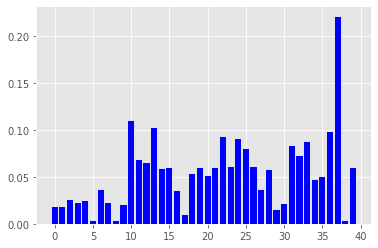

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [470]:
def correlation_selector(x, y):
    correl_dict = {
        col: np.corrcoef(x[col], y)[0, 1] for col in x.columns.tolist()
    }
    correl_dict = {
        col: 0 if np.isnan(cor) else np.abs(cor) for col, cor in correl_dict.items()
    }
    plot_scores(list(correl_dict.values()), 'correlation')
    
    correl_dict = dict(sorted(correl_dict.items(), key=lambda item: item[1], reverse=True)[:top_n_feats])
    top_n = np.array([
        True if col in list(correl_dict.keys()) else False for col in x.columns.tolist()
    ])
    return top_n


corr_top_n = correlation_selector(X, Y)
corr_top_n

#### 3.2 Chi-Squared <a class="anchor" id="chi_sq"></a>

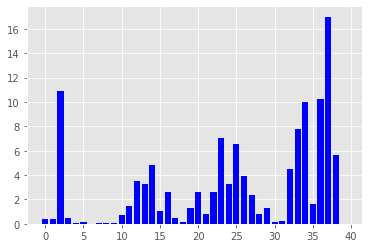

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

In [471]:
def chi_selector(y):
    chi_sq = SelectKBest(chi2, k=top_n_feats)
    chi_sq.fit(X_norm, y)
    top_n = chi_sq.get_support()
    plot_scores(chi_sq.scores_, 'chi-squared')
    return top_n


chi_top_n = chi_selector(Y)
chi_top_n

#### 3.3 Recursive Feature Elimination <a class="anchor" id="rfe"></a>

In [472]:
def rfe_selector(y):
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=top_n_feats, step=10, verbose=0)
    rfe.fit(X_norm, y)
    top_n = rfe.get_support()
    return top_n


rfe_top_n = rfe_selector(Y)
rfe_top_n

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True])

#### 3.4 Lasso: SelectFromModel <a class="anchor" id="lasso"></a>

In [473]:
def lasso_selector(y):
    lasso = SelectFromModel(LogisticRegression(penalty="l2"), max_features=top_n_feats)
    lasso.fit(X_norm, y)
    top_n = lasso.get_support()
    return top_n


lasso_top_n = lasso_selector(Y)
lasso_top_n

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([False, False, False,  True, False, False, False, False, False,
       False, False,  True, False,  True,  True, False,  True,  True,
        True, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False,  True, False,  True,  True,
       False,  True,  True, False])

#### 3.5 RandomForestClassifier: SelectFromModel <a class="anchor" id="rfc"></a>

In [474]:
def rfc_selector(x, y):
    rfc = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=top_n_feats)
    rfc.fit(x, y)
    top_n = rfc.get_support()
    return top_n


rfc_top_n = rfc_selector(X, Y)
rfc_top_n

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False, False])

#### 3.6 Cumulative Feature Selection <a class="anchor" id="cum"></a>

In [475]:
cumm_df = pd.DataFrame({
    'feature': X.columns.tolist(),
    'correlation': corr_top_n,
    'chi-sq': chi_top_n,
    'rfe': rfe_top_n,
    'lasso': lasso_top_n,
    'rfc': rfc_top_n
})
cumm_df['total'] = np.sum(cumm_df, axis=1)
cumm_df = cumm_df.sort_values(['total', 'feature'], ascending=False)
cumm_df.index = range(1, len(cumm_df) + 1)
cumm_df

,feature,correlation,chi-sq,rfe,lasso,rfc,total
1,heart_rate,True,True,True,True,True,5
2,cbc_platelets,True,True,True,True,True,5
3,Ethnicity_Encoded,True,True,True,True,True,5
4,wght,True,True,True,False,True,4
5,sbp,True,True,True,False,True,4
6,resp_rate,True,True,True,False,True,4
7,pulse_ox,True,True,True,False,True,4
8,patno,True,True,True,False,True,4
9,index,True,True,True,False,True,4
10,dbp,True,True,True,False,True,4


In [476]:
top_n_features = list(cumm_df.iloc[:top_n_feats]['feature'])
top_n_features

['heart_rate',
 'cbc_platelets',
 'Ethnicity_Encoded',
 'wght',
 'sbp',
 'resp_rate',
 'pulse_ox',
 'patno',
 'index',
 'dbp',
 'cmp_total_protein',
 'cmp_sodium',
 'cmp_bilirubin',
 'cbc_wbc',
 'cbc_neutrophil_c',
 'cbc_monocyte_c',
 'cbc_lymphocyte_perc',
 'cbc_lymphocyte_c',
 'cbc_hematocrit',
 'cbc_eosinophil_c',
 'Sex_Encoded',
 'FirstRace_Encoded',
 'Age',
 'Admitted',
 'height',
 'cmp_potassium',
 'cmp_glucose',
 'cmp_creatinine',
 'cmp_chloride',
 'cmp_bun',
 'cmp_bicarbonate',
 'cmp_ast',
 'cmp_alt',
 'cmp_alkaline_phosphatase',
 'cmp_albumin',
 'cbc_hemoglobin',
 'cbc_eosinophil_perc.2',
 'cbc_eosinophil_perc.1',
 'cbc_eosinophil_perc',
 'AdmittingDepartment_Encoded']

## 4. Model Selection <a class="anchor" id="model"></a>

[Table of Contents](#toc)

#### 4.1 Train / Test Data <a class="anchor" id="tt"></a>

In [477]:
X_train = final_train[top_n_features]
y_train = final_train[target]
X_test = final_test[top_n_features]
y_test = final_test[target]

In [478]:
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print()
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (5904, 40)
y_train (5904,)

X_test (1476, 40)
y_test (1476,)


#### 4.2 Model Evaluation Functions <a class="anchor" id="funcs"></a>

In [479]:
def plot_metric(hist, metric):
    train_metrics = hist.history[metric]
    val_metrics = hist.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and Validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [480]:
def plot_history(hist):
    display(Markdown('**Training/Validation Loss and Accuracy**'))
    pd.DataFrame(hist.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [481]:
def metric_evaluation(y_test, y_pred, labels=True):
    if labels:
        display(Markdown('**Metric Scores**'))
    print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))
    print("Precision: {:.2f}%".format(precision_score(y_test, y_pred) * 100))
    print("Recall: {:.2f}%".format(recall_score(y_test, y_pred) * 100))
    print("F1: {:.2f}%".format(f1_score(y_test, y_pred) * 100))
    if labels:
        display(Markdown('**Confusion Matrix**'))
    print(confusion_matrix(y_test, y_pred))

In [482]:
def plot_confusion_matrix(y_test, y_pred, labels=['None Detected', 'Detected']):
    cm_df = pd.DataFrame(
        confusion_matrix(y_test, y_pred), columns=labels, index=labels
    )
    ax = sns.heatmap(
        data=cm_df, cmap=cm.Blues, annot=True, fmt='d'
    )
    ax.set(xlabel='Predicted', ylabel='Actual')
    plt.show()

In [483]:
EPOCHS = 30
BATCH_SIZE = 200
VAL_SPLIT = 0.2

In [484]:
def test_models(models, xy, isolate=None):
    X_train, y_train, X_test, y_test = xy
    X_train = np.array(X_train.values.tolist())
    y_train = np.array(y_train)
    for i, m in enumerate(models):
        name, model, loss, optimizer, binary = m.values()
        if isolate is not None and i + 1 != isolate:
            print('Skipping Model {}...'.format(i + 1))
            continue
        
        display(Markdown('### Model {} – {}'.format(i + 1, name)))
        
        # 1. Compile
        model.compile(
            loss=loss, optimizer=optimizer, metrics=['accuracy']
        )
        
        # 2. Fit
        history = model.fit(
            X_train, y_train,
            batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VAL_SPLIT, shuffle=True, verbose=0
        )
        
        # 3. Visualize Model
        display(Markdown("**Summary**"))
        model.summary()
        plot_history(history)
        
        # 4. Evaluate
        display(Markdown("**Evaluation and Prediction**"))
        loss, accuracy = model.evaluate(x=X_test, y=y_test)
        print("\nLoss: {:.2f}%".format(loss * 100))
        print("Accuracy: {:.2f}%".format(accuracy * 100))
        
        # 5. Predict
        y_prediction_array = model.predict(X_test)
        
        if not binary:
            y_prediction = np.argmax(y_prediction_array, axis=1)
        else:
            y_prediction = np.round(y_prediction_array)
        
        # 6. Visualize Predictions
        metric_evaluation(y_test, y_prediction)
        plot_confusion_matrix(y_test, y_prediction)
        
        print()

#### 4.3 Model Construction <a class="anchor" id="models"></a>

In [485]:
tf.keras.backend.set_floatx('float64')
tf.set_random_seed(SEED)
np.random.seed(SEED)

###### 4.3.1 Decision Trees <a class="anchor" id="dt"></a>

**Metric Scores**

Accuracy: 94.11%
Precision: 100.00%
Recall: 5.43%
F1: 10.31%


**Confusion Matrix**

[[1384    0]
 [  87    5]]


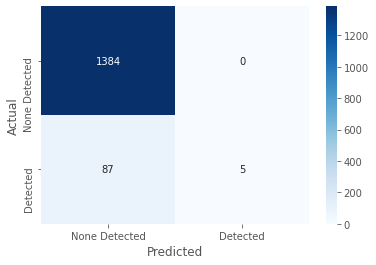

In [486]:
dt = DecisionTreeClassifier(
    max_depth=4, criterion="entropy", random_state=SEED
)
dt = dt.fit(X_train, y_train)
y_prediction = dt.predict(X_test)
metric_evaluation(y_test, y_prediction)
plot_confusion_matrix(y_test, y_prediction)

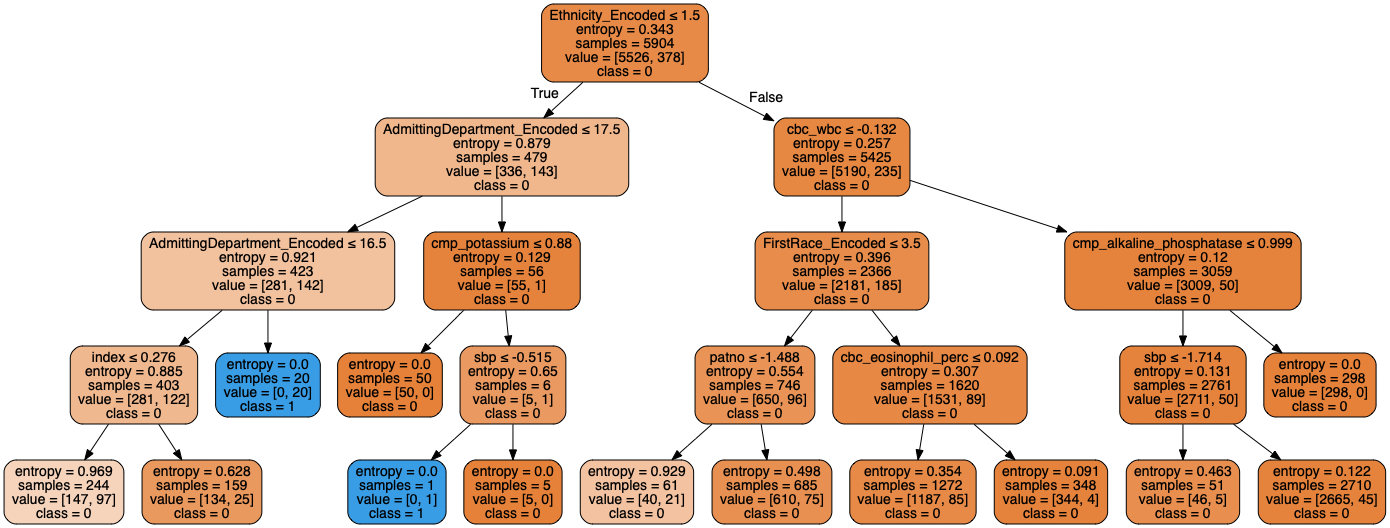

In [487]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=top_n_features, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('rfc.png')
Image(graph.create_png())

###### 4.3.2 Random Forest Classifier <a class="anchor" id="rfc2"></a>

**Metric Scores**

Accuracy: 94.17%
Precision: 87.50%
Recall: 7.61%
F1: 14.00%


**Confusion Matrix**

[[1383    1]
 [  85    7]]


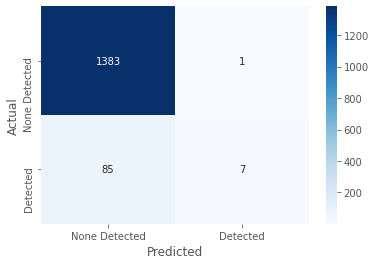

In [488]:
rfc = RandomForestClassifier(
    n_estimators=100, bootstrap=True, max_features='sqrt', random_state=SEED
)
rfc.fit(X_train, y_train)
y_prediction = rfc.predict(X_test)
metric_evaluation(y_test, y_prediction)
plot_confusion_matrix(y_test, y_prediction)

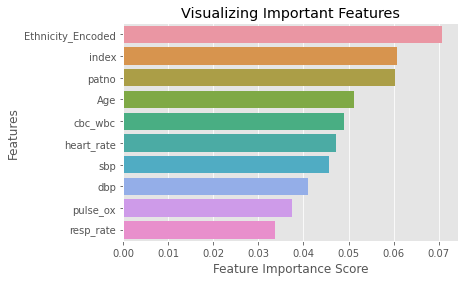

In [489]:
feature_importance = pd.Series(rfc.feature_importances_,index=top_n_features).sort_values(ascending=False).iloc[:10]
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

###### 4.3.3 Simple Deep Neural Network <a class="anchor" id="dnn"></a>

In [490]:
dnn = Sequential([
    Dense(top_n_feats//2, activation='relu', input_shape=(top_n_feats,)),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='softmax')
])

### Model 1 – Simple Deep Neural Network

**Summary**

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_488 (Dense)            (None, 20)                820       
_________________________________________________________________
dense_489 (Dense)            (None, 8)                 168       
_________________________________________________________________
dense_490 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_491 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_492 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_493 (Dense)            (None, 2)                 10        
Total params: 1,178
Trainable params: 1,178
Non-trainable params: 0
___________________________________________________

**Training/Validation Loss and Accuracy**

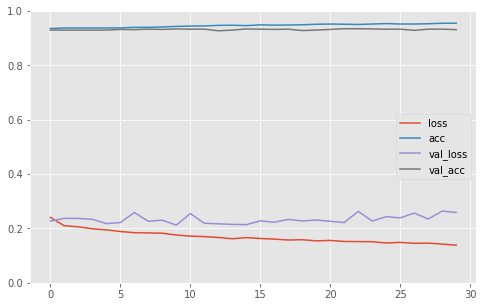

**Evaluation and Prediction**


Loss: 23.66%
Accuracy: 93.43%


**Metric Scores**

Accuracy: 93.43%
Precision: 40.74%
Recall: 11.96%
F1: 18.49%


**Confusion Matrix**

[[1368   16]
 [  81   11]]


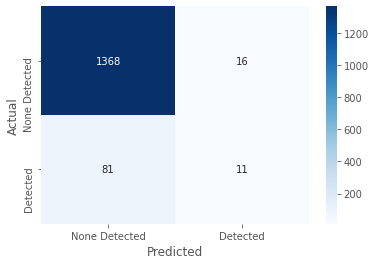

In [491]:
test_models([
    {'name': 'Simple Deep Neural Network', 'model': dnn,
     'loss': 'sparse_categorical_crossentropy', 'optimizer': RMSprop(learning_rate=1e-2), 'binary': False}
], (X_train, y_train, X_test, y_test))

###### 4.3.4 Convolutional Neural Network <a class="anchor" id="cnn"></a>

In [492]:
# cnn = Sequential([
#     Conv2D(32, kernel_size=(3, 3), activation='linear', input_shape=(top_n_feats,0,0), padding='same'),
#     LeakyReLU(alpha=0.1),
#     MaxPooling2D((2, 2), padding='same'),
#     Conv2D(64, (3, 3), activation='linear',padding='same'),
#     LeakyReLU(alpha=0.1),
#     MaxPooling2D(pool_size=(2, 2), padding='same'),
#     Conv2D(128, (3, 3), activation='linear',padding='same'),
#     LeakyReLU(alpha=0.1),
#     MaxPooling2D(pool_size=(2, 2), padding='same'),
#     Flatten(),
#     Dense(128, activation='linear'),
#     LeakyReLU(alpha=0.1),
#     Dense(2, activation='softmax')
# ])

###### All Models

In [493]:
model_lst = []

###### Retired Models

In [494]:
# MLPs are more linear...
mlp1 = Sequential([
    Dense(12, input_dim=top_n_feats, kernel_initializer='uniform', activation='relu'),
    Dense(8, kernel_initializer='uniform', activation='relu'),
    Dense(1, kernel_initializer='uniform', activation='sigmoid')
])
mlp2 = Sequential([
    Dense(top_n_feats, activation='relu'),
    Dropout(0.2),
    Dense(10, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')
])
mlp3 = Sequential([
    Dense(64,activation='relu',input_dim=X_train.shape[1]),
    Dense(1)
])
seq = Sequential([
    Dense(top_n_feats, activation='relu'),
    Dense(6, activation='relu'),
    Dense(2, activation='softmax')
])

# RNNs are more for Time-Series Data
rnn = Sequential([
    Embedding(len(X_train) + 1, 64),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])
#model_lst = [
#     {'name': 'MLP: Binary Classification', 'model': mlp1,
#      'loss': 'binary_crossentropy', 'optimizer': Adam(learning_rate=1e-2), 'binary': True},
#     {'name': 'MLP: Multi-Class Classification', 'model': mlp2,
#      'loss': 'sparse_categorical_crossentropy', 'optimizer': RMSprop(learning_rate=1e-2), 'binary': False},
#     {'name': 'MLP: Regression', 'model': mlp3,
#      'loss': 'mse', 'optimizer': RMSprop(learning_rate=1e-2), 'binary': False},
#     {'name': 'Sequential: Dense Layers, ReLU Activation', 'model': seq,
#      'loss': 'sparse_categorical_crossentropy', 'optimizer': Adam(learning_rate=1e-2), 'binary': False},
#     {'name': 'Convolutional Neural Network', 'model': cnn,
#      'loss': 'sparse_categorical_crossentropy', 'optimizer': RMSprop(learning_rate=1e-4, decay=1e-6), 'binary': False},
#     {'name': 'Recurrent Neural Network', 'model': rnn,
#      'loss': 'binary_crossentropy', 'optimizer': Adam(learning_rate=1e-4), 'binary': True},
# ]

#### 4.4 Simultaneous Model Evaluation <a class="anchor" id="eval"></a>

In [495]:
test_models(model_lst, (X_train, y_train, X_test, y_test))

#### 4.5 Randomized Search <a class="anchor" id="search"></a>

In [496]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[top_n_feats]):
    model = Sequential([
        InputLayer(input_shape=input_shape)
    ])
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(1))
    optimizer = SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [497]:
keras_reg = KerasRegressor(build_model)

In [498]:
hyperparameters = {
    'n_hidden': [0, 1, 2, 3],
    'n_neurons': np.arange(1, 100),
    'learning_rate': reciprocal(3e-4, 3e-2)
}

In [499]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=SEED)

In [500]:
rnd_search_cv = RandomizedSearchCV(keras_reg, hyperparameters, n_iter=10, cv=cv)

In [501]:
run = False

In [502]:
%%time
if run:
    rnd_search_cv.fit(
        X_train, y_train, epochs=EPOCHS, validation_split=VAL_SPLIT, callbacks=[EarlyStopping(patience=10)], verbose=0
    )

CPU times: user 7 µs, sys: 5 µs, total: 12 µs
Wall time: 21.9 µs


In [503]:
def rnd_search_results(rscv):
    global final_top_x_models
    
    # 1. Best Model Params
    display(Markdown("**Best Parameters**"))
    best_params = rscv.best_params_
    for k, v in best_params:
        print(k + ":", v)
    print("Best Score: {}".format(rscv.best_score_))
    
    # 2. CV Results
    cv_results = pd.DataFrame(rnd_search_cv.cv_results_)
    print(cv_results)
    
    # 3. Top X
    top_x = 3
    top_x_models = cv_results.loc[cv_results['rank_test_score'].isin(range(1, top_x+1))].sort_values(
        by=['rank_test_score']
    )
    final_top_x_models = top_x_models.reset_index()
    print(final_top_x_models)
    
    # 4. Best!
    print(cv_results.iloc[rnd_search_cv.best_index_])

    
if run:
    rnd_search_results(rnd_search_cv)

In [504]:
def build_model2(n_hidden, n_neurons):
    model = Sequential([
        InputLayer(input_shape=[top_n_feats])
    ])
    for layer in range(n_hidden):
        model.add(Dense(n_neurons, activation="relu"))
    model.add(Dense(1))
    return model

In [505]:
# best_models_list = [{
#     'name': 'Randomized Search: #{} Model'.format(idx + 1),
#     'model': build_model2(n_hidden=model['param_n_hidden'], n_neurons=model['param_n_neurons']),
#     'loss': 'sparse_categorical_crossentropy',
#     'optimizer': SGD(learning_rate=model['param_learning_rate'])
# } for idx, model in final_top_x_models.iterrows()]

In [506]:
# best_models_list

In [507]:
# test_models(best_models_list, (X_train, y_train, X_test, y_test))

## 5. Generative Adverserial Networks (GAN) <a class="anchor" id="gan"></a>

[Table of Contents](#toc)

#### 5.1 Network Setup <a class="anchor" id="setup2"></a>

In [508]:
RAND_DIM = 32
NB_STEPS = 500 + 1
BASE_N_COUNT = 128
BATCH_SIZE = 128
NUM_UPDATES_D = 1         # number of critic network updates per adversarial training step
NUM_UPDATES_G = 1         # number of generator network updates per adversarial training step
NUM_PRE_TRAIN_STEPS = 100 # number of steps to pre-train the critic before starting adversarial training
LOG_INTERVAL = 100        # interval (in steps) at which to log loss summaries and save plots of image samples to disc
LEARNING_RATE = 5e-4 
DIRECTORY = 'GAN/outputs/'
SHOW = True
generator_model_path, discriminator_model_path, loss_pickle_path = None, None, None

arguments = [
    RAND_DIM, NB_STEPS, BATCH_SIZE, NUM_UPDATES_D, NUM_UPDATES_G, NUM_PRE_TRAIN_STEPS, LOG_INTERVAL,
    LEARNING_RATE, BASE_N_COUNT, DIRECTORY, generator_model_path, discriminator_model_path, loss_pickle_path, SHOW
]

In [509]:
all_data = False

In [510]:
target = 'COVIDResult_Encoded'
if all_data:
    train = final_data.copy()
else:
    all_detected = final_data.loc[final_data[target] == 1]
    train = all_detected.copy().reset_index(drop=True)

In [511]:
all_columns = list(train.columns.tolist())
data_cols = all_columns[:-1]
label_cols = [target]
train_no_label = train[data_cols] / 10

In [512]:
train.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_alkaline_phosphatase,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded
0,-1.728061,-1.728061,0.383537,0.742246,1.413939,0.801611,0.313307,-0.118924,-0.254819,0.928464,...,-0.385608,0.516674,0.724257,-0.209524,0,2.0,1.0,0.0,1.0,1.0
1,-1.723367,-1.723367,0.511066,-0.007125,1.997363,0.974970,-0.607210,0.592883,-0.254819,-0.760847,...,0.037869,0.901837,0.667883,-0.077870,1,9.0,2.0,0.0,30.0,1.0
2,-1.719143,-1.719143,1.488788,-0.215283,-0.303922,0.686038,-0.344205,0.165799,-0.254819,-0.760847,...,-0.287882,0.605558,0.498760,-0.077870,1,9.0,2.0,0.0,30.0,1.0
3,-1.714449,-1.714449,-1.104301,1.241826,-0.401159,-0.007399,-0.475707,2.728304,-0.254819,-0.760847,...,-0.331316,-1.498025,0.329637,-0.143697,1,9.0,2.0,1.0,30.0,1.0
4,-1.698959,-1.698959,0.893653,-0.798127,-1.405946,-1.220915,-1.133219,0.450522,3.495933,1.138256,...,-0.450758,0.546302,0.386011,-0.209524,1,0.0,2.0,0.0,30.0,1.0


#### 5.2 Train GAN Models <a class="anchor" id="train"></a>

In [513]:
gan_model = 'cgan'

###### 5.2.1 GAN <a class="anchor" id="gan2"></a>

In [514]:
%%time
# GAN
if gan_model == 'gan':
    GAN.adversarial_training_GAN(
        arguments=arguments, train=train_no_label, data_cols=data_cols, seed=SEED
    )

CPU times: user 4 µs, sys: 3 µs, total: 7 µs
Wall time: 12.9 µs


###### 5.2.2 CGAN <a class="anchor" id="cgan"></a>

data_dim:  40
data_cols:  ['index', 'patno', 'Age', 'heart_rate', 'sbp', 'dbp', 'pulse_ox', 'resp_rate', 'height', 'wght', 'cbc_wbc', 'cbc_hematocrit', 'cbc_hemoglobin', 'cbc_platelets', 'cbc_neutrophil_c', 'cbc_eosinophil_perc', 'cbc_lymphocyte_c', 'cbc_lymphocyte_perc', 'cbc_eosinophil_c', 'cbc_eosinophil_perc.1', 'cbc_monocyte_c', 'cbc_eosinophil_perc.2', 'cmp_sodium', 'cmp_potassium', 'cmp_chloride', 'cmp_bicarbonate', 'cmp_bun', 'cmp_creatinine', 'cmp_glucose', 'cmp_alt', 'cmp_ast', 'cmp_alkaline_phosphatase', 'cmp_total_protein', 'cmp_albumin', 'cmp_bilirubin', 'Admitted', 'FirstRace_Encoded', 'Ethnicity_Encoded', 'Sex_Encoded', 'AdmittingDepartment_Encoded']
label_dim:  1
label_cols:  ['COVIDResult_Encoded']
Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_85 (InputLayer)           [(None, 32)]         0    

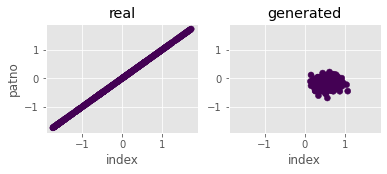

Step: 100 of 501.
Losses: G, D Gen, D Real, Xgb: 7.1303, 0.0859, 0.0398, 1.0000
D Real - D Gen: -0.0461


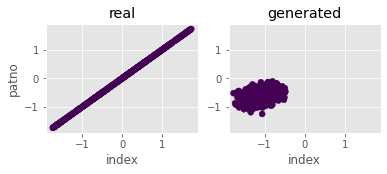

Step: 200 of 501.
Losses: G, D Gen, D Real, Xgb: 6.2571, 0.0413, 0.0356, 1.0000
D Real - D Gen: -0.0056


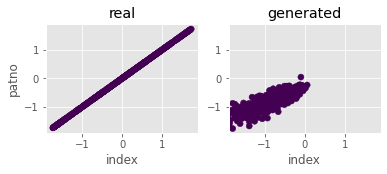

Step: 300 of 501.
Losses: G, D Gen, D Real, Xgb: 4.7758, 0.0732, 0.1243, 1.0000
D Real - D Gen: 0.0511


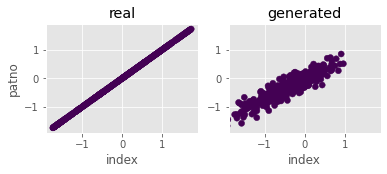

Step: 400 of 501.
Losses: G, D Gen, D Real, Xgb: 3.8333, 0.1144, 0.3269, 1.0000
D Real - D Gen: 0.2125


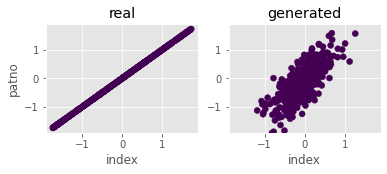

Step: 500 of 501.
Losses: G, D Gen, D Real, Xgb: 3.5873, 0.2227, 0.5107, 0.9979
D Real - D Gen: 0.2880


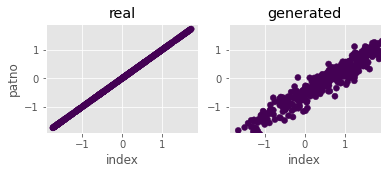

CPU times: user 1min 33s, sys: 4.37 s, total: 1min 38s
Wall time: 54.1 s


In [515]:
%%time
# CGAN
if gan_model == 'cgan':
    GAN.adversarial_training_GAN(
        arguments=arguments, train=train, data_cols=data_cols, label_cols=label_cols, seed=SEED
    )

###### 5.2.3 WGAN and WCGAN <a class="anchor" id="wgan"></a>

In [516]:
# %%time
# # WGAN
# GAN.adversarial_training_WGAN(
#     arguments=arguments, train=train_no_label, data_cols=data_cols, seed=SEED
# )
# # WCGAN
# GAN.adversarial_training_WGAN(
#     arguments=arguments, train=train, data_cols=data_cols, label_cols=label_cols, seed=SEED
# )

#### 5.3 Loss Information <a class="anchor" id="loss"></a>

CPU times: user 156 ms, sys: 7.47 ms, total: 163 ms
Wall time: 198 ms


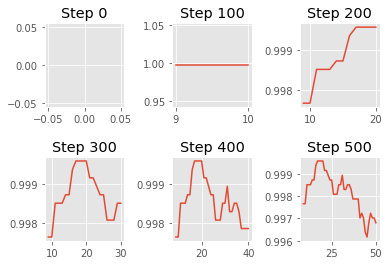

In [517]:
%%time
TYPE_ = 'CGAN'

fig = plt.figure()
fig.subplots_adjust(hspace=0.6, wspace=0.6)
for i, step in zip(range(1, 7), range(0, 600, 100)):
    [combined_loss, disc_loss_generated, disc_loss_real, xgb_losses] = pickle.load(
        open('{}{}_losses_step_{}.pkl'.format(DIRECTORY, TYPE_, step), 'rb')
    )
    
    ax = fig.add_subplot(2, 3, i)
    ax.plot(pd.DataFrame(xgb_losses).rolling(10).mean())
    ax.title.set_text('Step {}'.format(step))

#### 5.4 Generate New Data <a class="anchor" id="new_data"></a>

In [518]:
np.random.seed(SEED)
NEW = 6000
DATA_DIM = len(data_cols)
LABEL_DIM = len(label_cols)
WITH_CLASS = True if LABEL_DIM > 0 else False

In [519]:
def generate_helper(size, generator):
    """
    
    """
    x = GAN.get_data_batch(train, size, seed=SEED)
    labels = x[:, -LABEL_DIM:]
    
    if all_data: 
        z = np.random.normal(size=(size, RAND_DIM))
        g_z = generator.predict([z, labels]) if WITH_CLASS else generator.predict(z)
    else:
        for _ in range(NEW//size):
            new_z = np.random.normal(size=(size, RAND_DIM))
            new_g_z = generator.predict([new_z, labels]) if WITH_CLASS else generator.predict(new_z)
            try:
                g_z = np.append(g_z, new_g_z, axis=0)
            except:
                g_z = new_g_z
    
    return np.array(x), np.array(g_z)

Accuracy: 0.9990180032733225


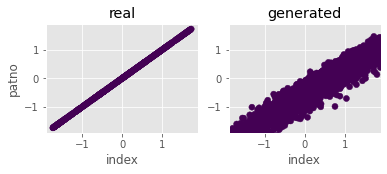

In [520]:
def generate():  
    """
    
    """
    # 1. Define Models
    generator, discriminator, combined = GAN.define_models_CGAN(
        RAND_DIM, DATA_DIM, LABEL_DIM, BASE_N_COUNT
    )
    generator.load_weights('GAN/outputs/CGAN_generator_model_weights_step_500.h5')
    
    # 2. Generate Batches of Data
    test_size = len(train)
    x, g_z = generate_helper(test_size, generator)
        
    # 3. Visualize Accuracy + New Data
    print("Accuracy:", GAN.CheckAccuracy(
        x, g_z, data_cols, label_cols, seed=SEED, with_class=WITH_CLASS, data_dim=DATA_DIM
    ))
    GAN.PlotData(
        x, g_z, data_cols, label_cols, seed=SEED, with_class=WITH_CLASS, data_dim=DATA_DIM
    )
    return x, g_z
    
batch, generated = generate()

#### 5.5 Test New Data on Models <a class="anchor" id="train_gan"></a>

In [521]:
real = pd.DataFrame(batch, columns=data_cols+label_cols)
real['syn_label'] = 0
real.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded,syn_label
0,0.394523,0.394523,0.936163,0.575719,-0.174272,-0.874197,0.181805,-0.403647,-0.254819,-0.760847,...,-1.498025,-1.587089,-0.407006,0.0,5.0,1.0,0.0,1.0,1.0,0
1,-0.019010,-0.019010,-0.041559,-0.090388,0.603627,0.108173,0.313307,-0.403647,-0.254819,-0.760847,...,-1.498025,-1.587089,-0.407006,0.0,0.0,2.0,0.0,1.0,1.0,0
2,-1.614938,-1.614938,-0.721714,-0.589969,-0.012210,-0.585264,0.313307,-0.546008,-0.254819,1.302216,...,0.872209,1.006128,-0.209524,0.0,0.0,2.0,1.0,1.0,1.0,0
3,1.124425,1.124425,-0.721714,-0.256915,-0.660459,-0.122972,0.444810,-0.118924,-0.254819,-0.760847,...,0.575930,0.498760,-0.077870,0.0,9.0,2.0,0.0,1.0,1.0,0
4,0.020888,0.020888,0.468557,0.242665,-0.271509,0.743825,-0.081200,0.450522,-0.254819,1.238310,...,0.901837,0.216888,0.382920,1.0,0.0,2.0,1.0,17.0,1.0,0


In [522]:
test = pd.DataFrame(generated, columns=data_cols+label_cols)
test['syn_label'] = 1
test.head(5)

,index,patno,Age,heart_rate,sbp,dbp,pulse_ox,resp_rate,height,wght,...,cmp_total_protein,cmp_albumin,cmp_bilirubin,Admitted,FirstRace_Encoded,Ethnicity_Encoded,Sex_Encoded,AdmittingDepartment_Encoded,COVIDResult_Encoded,syn_label
0,3.320332,2.093901,-1.637810,0.282035,-0.135744,-0.856914,0.602002,0.633633,-0.584309,-1.331451,...,-0.373461,-0.669984,-0.539870,-0.358887,5.429926,2.581850,0.704852,1.838328,1.0,1
1,0.067980,-0.782425,1.310445,-1.148728,0.845214,-1.147700,-1.158625,-0.482289,0.132335,-1.828641,...,1.814639,1.224926,0.876135,0.184988,6.883862,2.162872,0.204132,2.667255,1.0,1
2,1.130285,0.198781,0.863968,-1.247696,0.360260,-1.458871,-1.145448,-0.140931,-0.240367,-1.561105,...,0.783925,0.561043,0.509860,0.029693,10.396527,1.834441,0.456143,2.459618,1.0,1
3,3.288700,1.856246,1.632648,-1.754608,0.833567,-1.598306,-0.541121,-0.452344,0.100859,-1.897720,...,1.446812,1.029150,0.574230,0.176332,7.225274,2.219265,0.549414,2.803648,1.0,1
4,1.516017,0.591265,-1.079125,0.299093,-0.183249,-0.333720,-0.058808,0.714194,-0.688837,-0.780843,...,-0.702213,-0.741582,-0.214165,-0.188603,5.079613,1.287867,0.768589,1.359765,1.0,1


In [523]:
real.shape

(470, 42)

In [524]:
test.shape

(5640, 42)

In [525]:
SPLIT = 0.5

In [526]:
n_real, n_test = int(len(real)*SPLIT), int(len(test)*SPLIT)

In [527]:
train_gan = pd.concat([real[:n_real], test[:n_test]], axis=0)
train_gan = train_gan.sample(frac=1).reset_index(drop=True) # shuffle
test_gan = pd.concat([real[n_real:], test[n_test:]], axis=0)
test_gan = test_gan.sample(frac=1).reset_index(drop=True) # shuffle

In [528]:
X = train_gan.columns[:-2]
y = train_gan.columns[-1]
y_true = test_gan[y]
d_train = xgb.DMatrix(train_gan[X], train_gan[y], feature_names=X)
d_test = xgb.DMatrix(test_gan[X], feature_names=X)

In [529]:
parameters = {
    'max_depth': 4,
    'objective': 'binary:logistic',
    'random_state': SEED,
    'eval_metric': 'auc'
}
xgb_clf = xgb.train(parameters, d_train, num_boost_round=10)

**Metric Scores**

Accuracy: 99.90%
Precision: 99.93%
Recall: 99.96%
F1: 99.95%


**Confusion Matrix**

[[ 234    2]
 [   1 2818]]


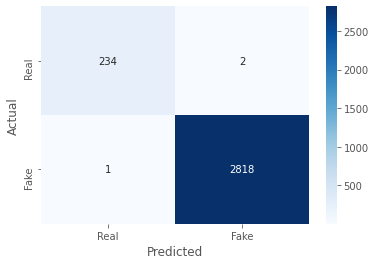

In [530]:
y_pred = xgb_clf.predict(d_test)
metric_evaluation(np.round(y_pred), y_true)
plot_confusion_matrix(np.round(y_pred), y_true, labels=['Real', 'Fake'])

#### 5.6 Plot Real vs Test Data <a class="anchor" id="plot"></a>

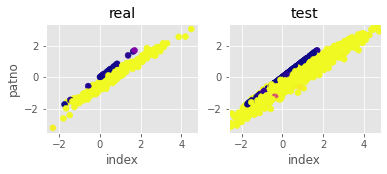

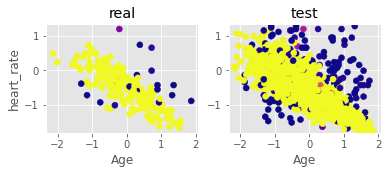

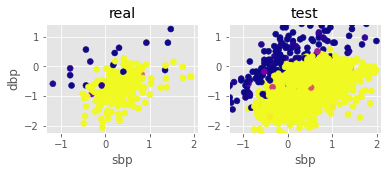

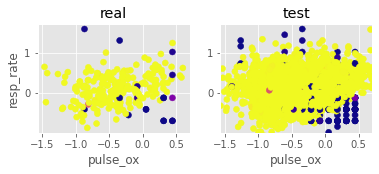

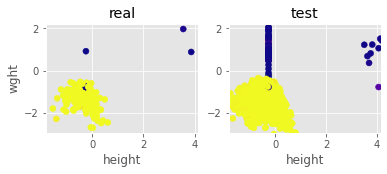

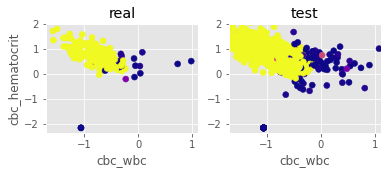

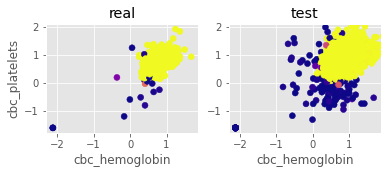

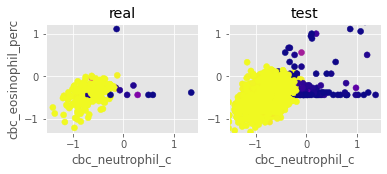

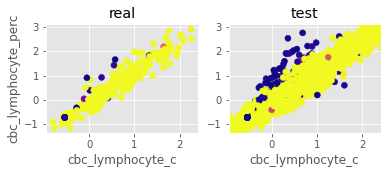

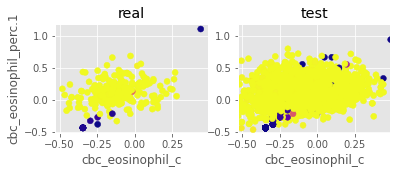

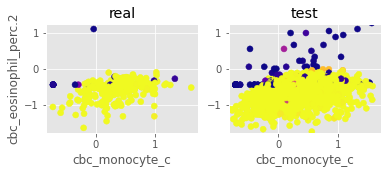

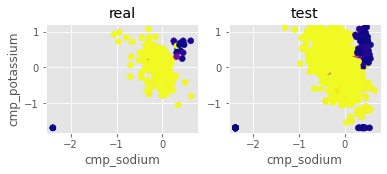

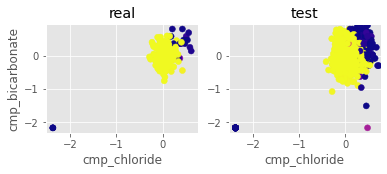

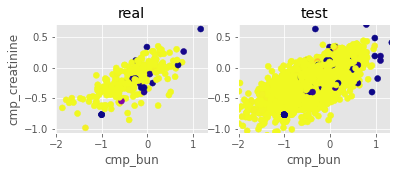

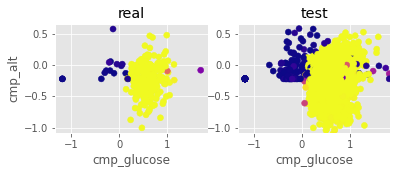

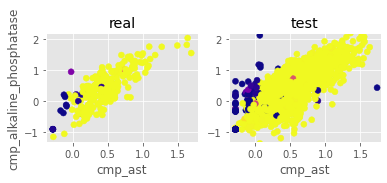

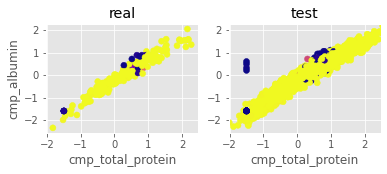

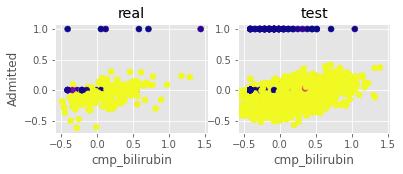

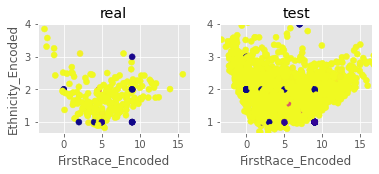

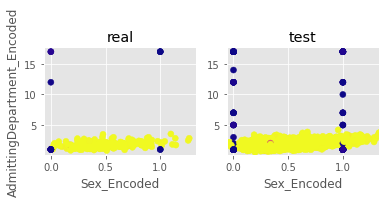

In [531]:
for i in range(0, len(X)-1, 2):
    fig, ax = plt.subplots(1, 2, figsize=(6,2))

    ax[0].scatter(test_gan[:n_real][X[i]], test_gan[:n_real][X[i + 1]], c=y_pred[:n_real], cmap='plasma')
    ax[0].set_title('real')
    ax[0].set_ylabel(X[i + 1])

    ax[1].scatter(test_gan[n_real:][X[i]], test_gan[n_real:][X[i + 1]], c=y_pred[n_real:], cmap='plasma')
    ax[1].set_title('test')
    ax[1].set_xlim(ax[0].get_xlim()), ax[1].set_ylim(ax[0].get_ylim())

    for a in ax:
        a.set_xlabel(X[i])

    plt.show()

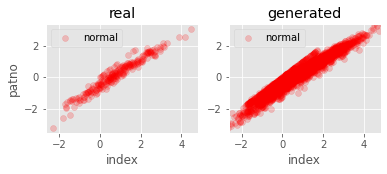

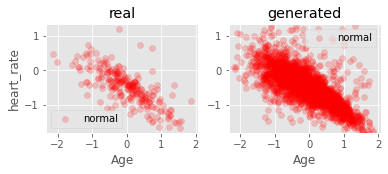

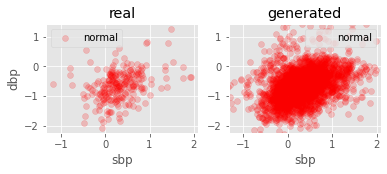

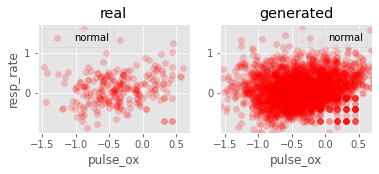

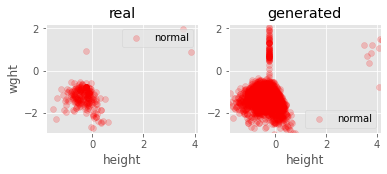

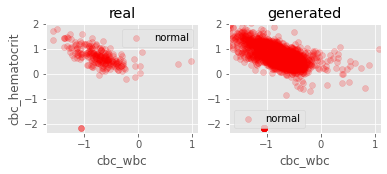

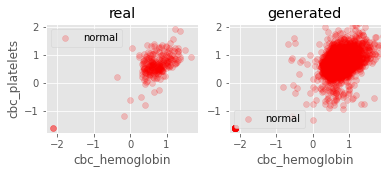

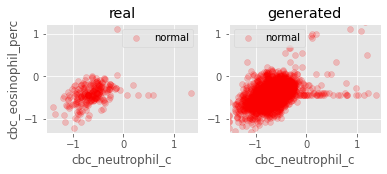

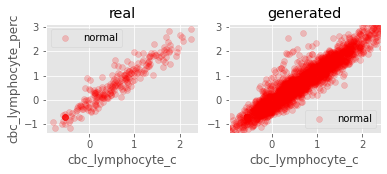

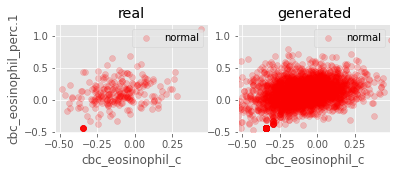

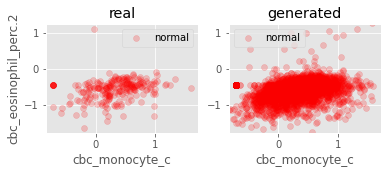

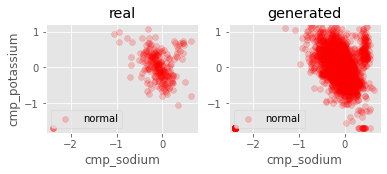

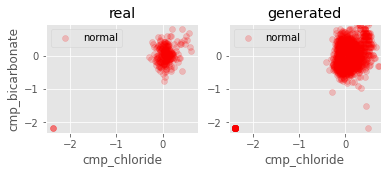

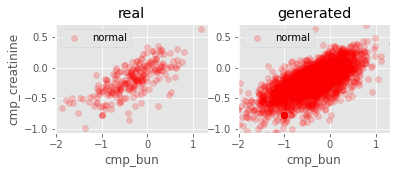

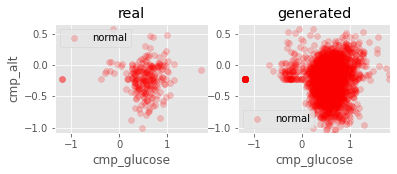

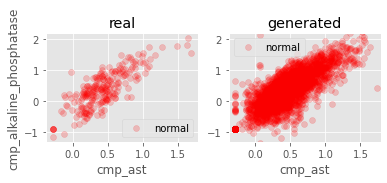

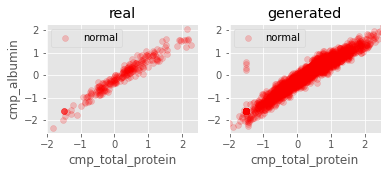

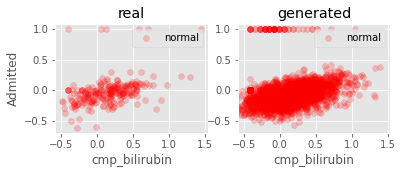

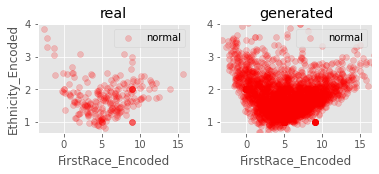

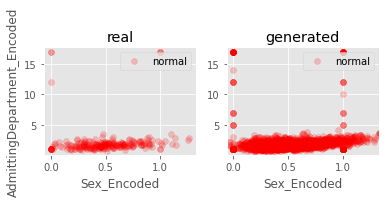

In [532]:
colors = ['red','blue']
markers = ['o','^']
labels = ['normal','detected']

target = 'COVIDResult_Encoded'

for i in range(0, len(X), 2):
    col1, col2 = i, i + 1
    if col2 >= len(X):
        continue
    
    fig, ax = plt.subplots(1, 2, figsize=(6,2))
    for group, color, marker, label in zip( test_gan[:n_real].groupby(target), colors, markers, labels):
        ax[0].scatter( group[1][X[col1]], group[1][X[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    ax[0].legend()
    ax[0].set_title('real')
    ax[0].set_ylabel(X[col2])

    for group, color, marker, label in zip( test_gan[n_real:].groupby(target), colors, markers, labels):
        ax[1].scatter(group[1][X[col1]], group[1][X[col2]], label=label, c=color, marker=marker, alpha=0.2) 
    ax[1].set_xlim(ax[0].get_xlim()), ax[1].set_ylim(ax[0].get_ylim())
    ax[1].legend()
    ax[1].set_title('generated')

    for a in ax:
        a.set_xlabel(X[col1])

    plt.show()

#### 5.7 Feature Importance <a class="anchor" id="importance"></a>

In [533]:
MAX_FEATURES = 20

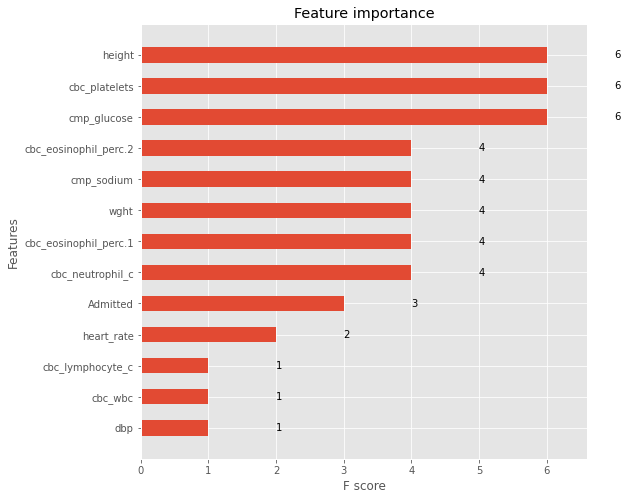

In [534]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
xgb.plot_importance(xgb_clf, max_num_features=MAX_FEATURES, height=0.5, ax=ax)
plt.show()

## 6. Retrain Models with GAN Data <a class="anchor" id="retrain"></a>

[Table of Contents](#toc)

#### 6.1 Re-Prepare Data <a class="anchor" id="prep2"></a>

In [535]:
real_data = final_data.copy()
fake_data = test.copy().drop(columns=['syn_label'])

In [536]:
combined = pd.concat([real_data, fake_data], axis=0)
combined = combined.sample(frac=1).reset_index(drop=True) # shuffle

In [537]:
combined.shape

(13020, 41)

In [538]:
retrain, retest = train_test_split(combined, test_size=0.5, random_state=SEED)

In [539]:
target = 'COVIDResult_Encoded'
X_cols = combined.columns.tolist()
X_cols.remove(target)

In [540]:
X_retrain = retrain[X_cols]
y_retrain = retrain[target]
X_retest = retest[X_cols]
y_retest = retest[target]

#### 6.2 Re-Train Models <a class="anchor" id="retrain2"></a>

**Metric Scores**

Accuracy: 96.37%
Precision: 99.97%
Recall: 92.40%
F1: 96.04%


**Confusion Matrix**

[[3415    1]
 [ 235 2859]]


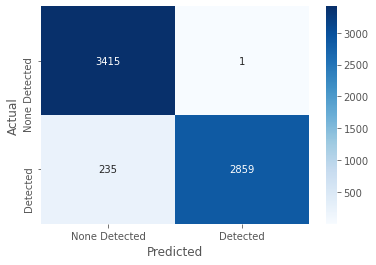

In [541]:
dt = DecisionTreeClassifier(
    max_depth=4, criterion="entropy", random_state=SEED
)
dt = dt.fit(X_retrain, y_retrain)
y_prediction = dt.predict(X_retest)
metric_evaluation(y_retest, y_prediction)
plot_confusion_matrix(y_retest, y_prediction)

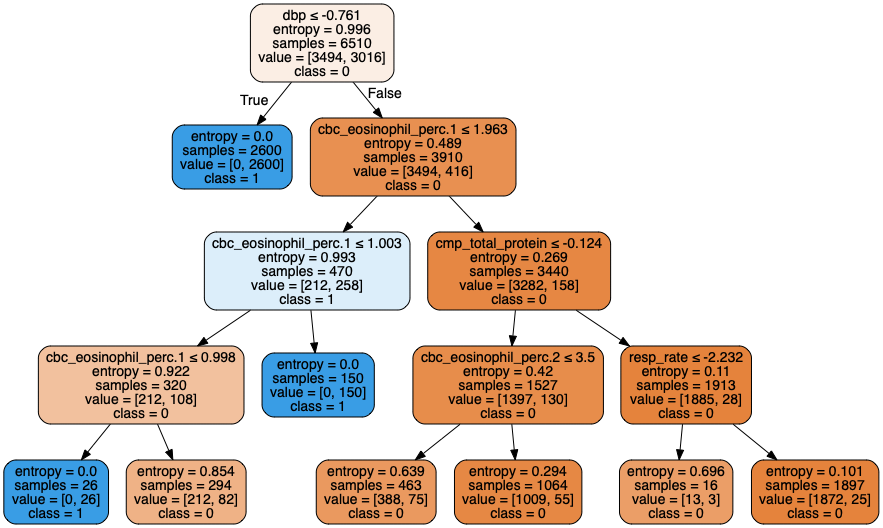

In [542]:
dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=top_n_features, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('rfc.png')
Image(graph.create_png())

**Metric Scores**

Accuracy: 96.62%
Precision: 99.72%
Recall: 93.15%
F1: 96.32%


**Confusion Matrix**

[[3408    8]
 [ 212 2882]]


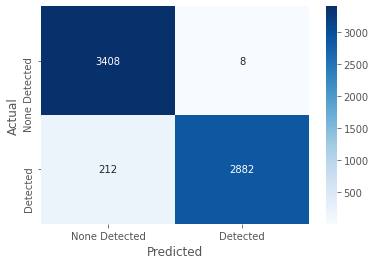

In [543]:
rfc = RandomForestClassifier(
    n_estimators=100, bootstrap=True, max_features='sqrt', random_state=SEED
)
rfc.fit(X_retrain, y_retrain)
y_prediction = rfc.predict(X_retest)
metric_evaluation(y_retest, y_prediction)
plot_confusion_matrix(y_retest, y_prediction)

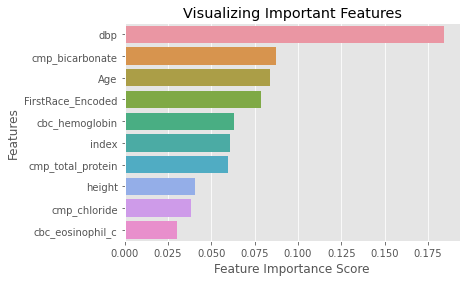

In [544]:
feature_importance = pd.Series(rfc.feature_importances_,index=top_n_features).sort_values(ascending=False).iloc[:10]
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [545]:
dnn = Sequential([
    Dense(top_n_feats//2, activation='relu', input_shape=(top_n_feats,)),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='softmax')
])

### Model 1 – Simple Deep Neural Network

**Summary**

Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_522 (Dense)            (None, 20)                820       
_________________________________________________________________
dense_523 (Dense)            (None, 8)                 168       
_________________________________________________________________
dense_524 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_525 (Dense)            (None, 8)                 72        
_________________________________________________________________
dense_526 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_527 (Dense)            (None, 2)                 10        
Total params: 1,178
Trainable params: 1,178
Non-trainable params: 0
___________________________________________________

**Training/Validation Loss and Accuracy**

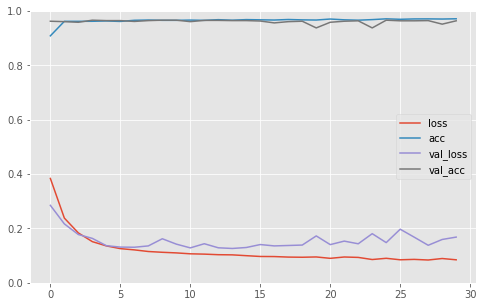

**Evaluation and Prediction**


Loss: 16.63%
Accuracy: 96.37%


**Metric Scores**

Accuracy: 96.37%
Precision: 98.47%
Recall: 93.83%
F1: 96.09%


**Confusion Matrix**

[[3371   45]
 [ 191 2903]]


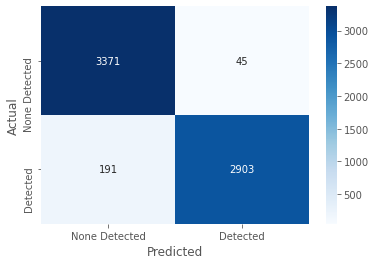

In [546]:
test_models([
    {'name': 'Simple Deep Neural Network', 'model': dnn,
     'loss': 'sparse_categorical_crossentropy', 'optimizer': RMSprop(learning_rate=1e-2), 'binary': False}
], (X_retrain, y_retrain, X_retest, y_retest))

## 7. Final Model Training with Feature Selection <a class="anchor" id="final"></a>

[Table of Contents](#toc)

#### 7.1 Define Models and Variables <a class="anchor" id="define"></a>

In [547]:
models = [
    DecisionTreeClassifier(max_depth=4, criterion="entropy", random_state=SEED),
    RandomForestClassifier(n_estimators=100, bootstrap=True, max_features='sqrt', random_state=SEED),
    'Sequential'
]
names = [
    'Decision Tree Classifier',
    'Random Forest Classifier',
    'Deep Neural Network'
]

In [548]:
for model in models:
    print(model)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Sequential


In [549]:
drops = [
    ('sbp', 'dbp'),
    'pulse_ox',
    'cmp_glucose',
    'resp_rate',
    None
]

In [550]:
metrics = [
    'Accuracy',
    'Precision',
    'Recall',
    'F1'
]

In [551]:
EPOCHS = 30
BATCH_SIZE = 200
VAL_SPLIT = 0.2

In [552]:
def metric_evaluation2(y_test, y_pred):
    acc = round(accuracy_score(y_test, y_pred) * 100, 2)
    prec = round(precision_score(y_test, y_pred) * 100, 2)
    rec = round(recall_score(y_test, y_pred) * 100, 2)
    f1 = round(f1_score(y_test, y_pred) * 100, 2)
    return [acc, prec, rec, f1]

In [553]:
def test_final_models(models_lst, xy):
    X_train, y_train, X_test, y_test = xy
    X_cols = [
        'Age',
        'FirstRace_Encoded',
        'Ethnicity_Encoded',
        'Sex_Encoded',
        'height',
        'wght',
        'heart_rate',
        'sbp',
        'dbp',
        'pulse_ox',
        'resp_rate',
        'cmp_glucose'
    ]
    
    metric_scores_lst = []
    index_tuples = []
    
    for num, drop in enumerate(drops):
        display(Markdown('#### {} Features'.format(len(X_cols))))
        metric_scores = []
        
        for model, name in zip(models_lst, names):
            display(Markdown('<u>{}</u>'.format(name)))
            
            if model == 'Sequential':
                nn = True
                model = Sequential([
                            Dense(len(X_cols)//2, activation='relu', input_shape=(len(X_cols),)),
                            Dense(8, activation='relu'),
                            Dense(8, activation='relu'),
                            Dense(8, activation='relu'),
                            Dense(4, activation='relu'),
                            Dense(2, activation='softmax')
                        ])
                model.compile(
                    loss='sparse_categorical_crossentropy',
                    optimizer=RMSprop(learning_rate=1e-2),
                    metrics=['accuracy']
                )
                model.fit(
                    X_train[X_cols], y_train,
                    batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VAL_SPLIT, shuffle=True, verbose=0
                )

            else:
                nn = False
                model.fit(X_train[X_cols], y_train)

            y_prediction = model.predict(X_test[X_cols])
            y_prediction = np.argmax(y_prediction, axis=1) if nn else np.round(y_prediction)
            metric_evaluation(y_test, y_prediction, labels=False)
            
            metric_scores.extend(metric_evaluation2(y_test, y_prediction))
            if num == 0:
                for metric in metrics:
                    index_tuples.append((name, metric))
                
        
        
        metric_scores_lst.append(metric_scores)
        
        if drop is not None:
            if not isinstance(drop, str):
                X_cols.remove(drop[0])
                display(Markdown('*Dropping {}...*'.format(drop[0])))
                X_cols.remove(drop[1])
                display(Markdown('*Dropping {}...*'.format(drop[1])))
                
            else:
                X_cols.remove(drop)
                display(Markdown('*Dropping {}...*'.format(drop)))
           
    index = pd.MultiIndex.from_tuples(index_tuples, names=['Classifier', 'Scores'])
    transposed = map(list, zip(*metric_scores_lst))
    return pd.DataFrame(transposed, columns=['12', '10', '9', '8', '7'], index=index)

#### 7.2 Model Performance without GAN (Real Data) <a class="anchor" id="perf1"></a>

In [554]:
%%time
metric_df1 = test_final_models(models, (X_train, y_train, X_test, y_test))

#### 12 Features

<u>Decision Tree Classifier</u>

Accuracy: 93.70%
Precision: 46.67%
Recall: 7.61%
F1: 13.08%
[[1376    8]
 [  85    7]]


<u>Random Forest Classifier</u>

Accuracy: 94.11%
Precision: 77.78%
Recall: 7.61%
F1: 13.86%
[[1382    2]
 [  85    7]]


<u>Deep Neural Network</u>

Accuracy: 93.70%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1383    1]
 [  92    0]]


*Dropping sbp...*

*Dropping dbp...*

#### 10 Features

<u>Decision Tree Classifier</u>

Accuracy: 93.70%
Precision: 46.67%
Recall: 7.61%
F1: 13.08%
[[1376    8]
 [  85    7]]


<u>Random Forest Classifier</u>

Accuracy: 93.97%
Precision: 61.54%
Recall: 8.70%
F1: 15.24%
[[1379    5]
 [  84    8]]


<u>Deep Neural Network</u>

Accuracy: 93.70%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1383    1]
 [  92    0]]


*Dropping pulse_ox...*

#### 9 Features

<u>Decision Tree Classifier</u>

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1384    0]
 [  92    0]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


<u>Random Forest Classifier</u>

Accuracy: 93.56%
Precision: 42.11%
Recall: 8.70%
F1: 14.41%
[[1373   11]
 [  84    8]]


<u>Deep Neural Network</u>

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1384    0]
 [  92    0]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


*Dropping cmp_glucose...*

#### 8 Features

<u>Decision Tree Classifier</u>

Accuracy: 93.77%
Precision: 50.00%
Recall: 3.26%
F1: 6.12%
[[1381    3]
 [  89    3]]


<u>Random Forest Classifier</u>

Accuracy: 93.56%
Precision: 40.00%
Recall: 6.52%
F1: 11.21%
[[1375    9]
 [  86    6]]


<u>Deep Neural Network</u>

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1384    0]
 [  92    0]]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


*Dropping resp_rate...*

#### 7 Features

<u>Decision Tree Classifier</u>

Accuracy: 93.77%
Precision: 50.00%
Recall: 3.26%
F1: 6.12%
[[1381    3]
 [  89    3]]


<u>Random Forest Classifier</u>

Accuracy: 93.16%
Precision: 28.57%
Recall: 6.52%
F1: 10.62%
[[1369   15]
 [  86    6]]


<u>Deep Neural Network</u>

Accuracy: 93.77%
Precision: 0.00%
Recall: 0.00%
F1: 0.00%
[[1384    0]
 [  92    0]]
CPU times: user 1min 1s, sys: 1.45 s, total: 1min 2s
Wall time: 1min


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [555]:
metric_df1

12     10      9      8      7
Classifier               Scores                                      
Decision Tree Classifier Accuracy   93.70  93.70  93.77  93.77  93.77
                         Precision  46.67  46.67   0.00  50.00  50.00
                         Recall      7.61   7.61   0.00   3.26   3.26
                         F1         13.08  13.08   0.00   6.12   6.12
Random Forest Classifier Accuracy   94.11  93.97  93.56  93.56  93.16
                         Precision  77.78  61.54  42.11  40.00  28.57
                         Recall      7.61   8.70   8.70   6.52   6.52
                         F1         13.86  15.24  14.41  11.21  10.62
Deep Neural Network      Accuracy   93.70  93.70  93.77  93.77  93.77
                         Precision   0.00   0.00   0.00   0.00   0.00
                         Recall      0.00   0.00   0.00   0.00   0.00
                         F1          0.00   0.00   0.00   0.00   0.00

#### 7.3 Model Performance with GAN <a class="anchor" id="perf2"></a>

In [556]:
%%time
metric_df2 = test_final_models(models, (X_retrain, y_retrain, X_retest, y_retest))

#### 12 Features

<u>Decision Tree Classifier</u>

Accuracy: 96.37%
Precision: 99.97%
Recall: 92.40%
F1: 96.04%
[[3415    1]
 [ 235 2859]]


<u>Random Forest Classifier</u>

Accuracy: 96.47%
Precision: 99.72%
Recall: 92.82%
F1: 96.15%
[[3408    8]
 [ 222 2872]]


<u>Deep Neural Network</u>

Accuracy: 96.21%
Precision: 99.69%
Recall: 92.31%
F1: 95.86%
[[3407    9]
 [ 238 2856]]


*Dropping sbp...*

*Dropping dbp...*

#### 10 Features

<u>Decision Tree Classifier</u>

Accuracy: 96.37%
Precision: 99.97%
Recall: 92.40%
F1: 96.04%
[[3415    1]
 [ 235 2859]]


<u>Random Forest Classifier</u>

Accuracy: 96.42%
Precision: 99.58%
Recall: 92.86%
F1: 96.10%
[[3404   12]
 [ 221 2873]]


<u>Deep Neural Network</u>

Accuracy: 91.12%
Precision: 87.17%
Recall: 95.35%
F1: 91.08%
[[2982  434]
 [ 144 2950]]


*Dropping pulse_ox...*

#### 9 Features

<u>Decision Tree Classifier</u>

Accuracy: 96.37%
Precision: 99.97%
Recall: 92.40%
F1: 96.04%
[[3415    1]
 [ 235 2859]]


<u>Random Forest Classifier</u>

Accuracy: 96.33%
Precision: 99.24%
Recall: 92.99%
F1: 96.01%
[[3394   22]
 [ 217 2877]]


<u>Deep Neural Network</u>

Accuracy: 95.59%
Precision: 97.69%
Recall: 92.92%
F1: 95.25%
[[3348   68]
 [ 219 2875]]


*Dropping cmp_glucose...*

#### 8 Features

<u>Decision Tree Classifier</u>

Accuracy: 96.37%
Precision: 99.97%
Recall: 92.40%
F1: 96.04%
[[3415    1]
 [ 235 2859]]


<u>Random Forest Classifier</u>

Accuracy: 96.30%
Precision: 99.10%
Recall: 93.05%
F1: 95.98%
[[3390   26]
 [ 215 2879]]


<u>Deep Neural Network</u>

Accuracy: 93.59%
Precision: 92.21%
Recall: 94.51%
F1: 93.34%
[[3169  247]
 [ 170 2924]]


*Dropping resp_rate...*

#### 7 Features

<u>Decision Tree Classifier</u>

Accuracy: 96.37%
Precision: 99.97%
Recall: 92.40%
F1: 96.04%
[[3415    1]
 [ 235 2859]]


<u>Random Forest Classifier</u>

Accuracy: 95.93%
Precision: 98.23%
Recall: 93.12%
F1: 95.60%
[[3364   52]
 [ 213 2881]]


<u>Deep Neural Network</u>

Accuracy: 95.45%
Precision: 97.17%
Recall: 93.15%
F1: 95.12%
[[3332   84]
 [ 212 2882]]
CPU times: user 1min 10s, sys: 1.61 s, total: 1min 11s
Wall time: 1min 7s


In [557]:
metric_df2

12     10      9      8      7
Classifier               Scores                                      
Decision Tree Classifier Accuracy   96.37  96.37  96.37  96.37  96.37
                         Precision  99.97  99.97  99.97  99.97  99.97
                         Recall     92.40  92.40  92.40  92.40  92.40
                         F1         96.04  96.04  96.04  96.04  96.04
Random Forest Classifier Accuracy   96.47  96.42  96.33  96.30  95.93
                         Precision  99.72  99.58  99.24  99.10  98.23
                         Recall     92.82  92.86  92.99  93.05  93.12
                         F1         96.15  96.10  96.01  95.98  95.60
Deep Neural Network      Accuracy   96.21  91.12  95.59  93.59  95.45
                         Precision  99.69  87.17  97.69  92.21  97.17
                         Recall     92.31  95.35  92.92  94.51  93.15
                         F1         95.86  91.08  95.25  93.34  95.12